## Differential expression analysis

In [1]:
import pandas as pd
import numpy as np

In [ ]:
expression = pd.read_csv('preprocessed_gene_expression.csv', index_col=0)
clinical = pd.read_csv('preprocessed_clinical_train.csv')

In [3]:
clinical = clinical[['sample', 'ajcc_pathologic_stage.diagnoses']].dropna()
clinical = clinical.rename(columns={'sample': 'sample_id', 'ajcc_pathologic_stage.diagnoses': 'stage'})
clinical = clinical.dropna(subset=["stage"])
clinical

,sample_id,stage
0,TCGA-HN-A2NL-01A,II
1,TCGA-D8-A1XZ-01A,III+IV
2,TCGA-AR-A254-01A,III+IV
3,TCGA-C8-A1HN-01A,II
4,TCGA-AR-A0TR-01A,II
...,...,...
607,TCGA-E9-A1NA-01A,II
608,TCGA-E9-A247-01A,I
609,TCGA-EW-A1J6-01A,I
610,TCGA-GM-A3XG-01A,III+IV


In [4]:
common_samples = [s for s in clinical["sample_id"] if s in expression.columns]
expression = expression[common_samples]
clinical = clinical.set_index("sample_id").loc[common_samples]
clinical

,stage
sample_id,
TCGA-HN-A2NL-01A,II
TCGA-D8-A1XZ-01A,III+IV
TCGA-AR-A254-01A,III+IV
TCGA-C8-A1HN-01A,II
TCGA-AR-A0TR-01A,II
...,...
TCGA-E9-A1NA-01A,II
TCGA-E9-A247-01A,I
TCGA-EW-A1J6-01A,I


In [5]:
stage_map = clinical['stage']

### ANOVA

In [6]:
from scipy.stats import f_oneway

#group samples by stage
grouped_samples = stage_map.groupby(stage_map).groups  #dict: {stage: [sampleIDs]}

#run ANOVA for each gene
results = []

for gene, values in expression.iterrows():
    group_exprs = [values[sample_list].values for sample_list in grouped_samples.values()]
    
    if all(len(g) >= 3 for g in group_exprs):  
        f_stat, pval = f_oneway(*group_exprs)
        results.append((gene, f_stat, pval))


anova_df = pd.DataFrame(results, columns=["gene", "f_statistic", "p_value"])


In [7]:
anova_df

,gene,f_statistic,p_value
0,ENSG00000000419,0.658026,0.518241
1,ENSG00000000457,1.336201,0.263612
2,ENSG00000000460,2.709927,0.067344
3,ENSG00000000938,5.035646,0.006775
4,ENSG00000000971,5.647406,0.003714
...,...,...,...
20012,ENSG00000288586,3.189616,0.041877
20013,ENSG00000288596,0.610105,0.543626
20014,ENSG00000288612,0.157154,0.854607
20015,ENSG00000288670,0.584061,0.557941


In [8]:
from statsmodels.stats.multitest import multipletests

anova_df["fdr"] = multipletests(anova_df["p_value"], method="fdr_bh")[1]
anova_df = anova_df.sort_values("fdr")

In [9]:
anova_df.head(10)

,gene,f_statistic,p_value,fdr
1537,ENSG00000089159,12.540894,0.000005,0.023018
4380,ENSG00000122035,13.235148,0.000002,0.023018
2330,ENSG00000103647,13.347142,0.000002,0.023018
6341,ENSG00000138722,12.602536,0.000004,0.023018
6464,ENSG00000139679,12.132947,0.000007,0.027254
11189,ENSG00000177363,11.345802,0.000015,0.034986
17179,ENSG00000256235,11.138725,0.000018,0.034986
10817,ENSG00000174348,11.361375,0.000014,0.034986
7961,ENSG00000154721,11.055209,0.000019,0.034986
4141,ENSG00000119681,11.248687,0.000016,0.034986


/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_22188/1680489517.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="stage", y="expression", palette="pastel")


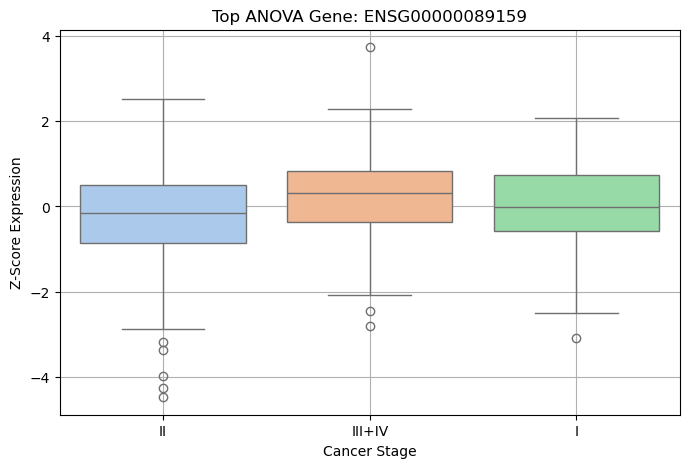

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

top_gene = anova_df.iloc[0]["gene"]
plot_df = pd.DataFrame({
    "expression": expression.loc[top_gene],
    "stage": stage_map
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x="stage", y="expression", palette="pastel")
plt.title(f"Top ANOVA Gene: {top_gene}")
plt.xlabel("Cancer Stage")
plt.ylabel("Z-Score Expression")
plt.grid(True)
plt.show()

### Kruskal Wallis

In [ ]:
from scipy.stats import kruskal

#run Kruskal–Wallis test for each gene
results_kw = []

for gene, values in expression.iterrows():
    group_exprs = [values[sample_list].values for sample_list in grouped_samples.values()]
    
    if all(len(g) >= 3 for g in group_exprs):  
        stat, pval = kruskal(*group_exprs)
        results_kw.append((gene, stat, pval))

kw_df = pd.DataFrame(results_kw, columns=["gene", "kruskal_statistic", "p_value"])

In [12]:
kw_df["fdr"] = multipletests(kw_df["p_value"], method="fdr_bh")[1]
kw_df = kw_df.sort_values("fdr")

In [30]:
kw_df.head(15)

,gene,kruskal_statistic,p_value,fdr
4380,ENSG00000122035,26.465184,0.000002,0.017928
6341,ENSG00000138722,27.311632,0.000001,0.017928
6464,ENSG00000139679,23.948097,0.000006,0.027272
2330,ENSG00000103647,23.974893,0.000006,0.027272
1537,ENSG00000089159,23.793608,0.000007,0.027272
11189,ENSG00000177363,22.997948,0.000010,0.033830
11579,ENSG00000180875,21.456702,0.000022,0.036556
8057,ENSG00000155957,22.445106,0.000013,0.036556
12463,ENSG00000188064,21.618139,0.000020,0.036556
7454,ENSG00000149090,21.928982,0.000017,0.036556


In [32]:
sig_genes_kw = kw_df[kw_df["fdr"] < 0.05]
sig_genes_kw.head(30)

,gene,kruskal_statistic,p_value,fdr
4380,ENSG00000122035,26.465184,0.000002,0.017928
6341,ENSG00000138722,27.311632,0.000001,0.017928
6464,ENSG00000139679,23.948097,0.000006,0.027272
2330,ENSG00000103647,23.974893,0.000006,0.027272
1537,ENSG00000089159,23.793608,0.000007,0.027272
11189,ENSG00000177363,22.997948,0.000010,0.033830
11579,ENSG00000180875,21.456702,0.000022,0.036556
8057,ENSG00000155957,22.445106,0.000013,0.036556
12463,ENSG00000188064,21.618139,0.000020,0.036556
7454,ENSG00000149090,21.928982,0.000017,0.036556


In [ ]:
for gene in sig_genes_kw['gene']:  
    plt.figure(figsize=(6, 4))
    sns.violinplot(x=stage_map.values,
                y=expression.loc[gene, stage_map.index].values,
                order=["I", "II", "III+IV"], palette="YlGnBu")
    plt.title(f"{gene} Expression Across Stages")
    plt.xlabel("Cancer Stage")
    plt.ylabel("Z-scored Expression")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

### Dunn's post hoc

In [ ]:
import scikit_posthocs as sp

#stage to categorical
sample_stage = stage_map.loc[expression.columns]


dunn_results = []

for gene in expression.index:
    expr = expression.loc[gene]
    
    df = pd.DataFrame({
        'expression': expr.values,
        'stage': sample_stage.values
    })

    dunn = sp.posthoc_dunn(df, val_col='expression', group_col='stage', p_adjust='fdr_bh')
    dunn['gene'] = gene
    dunn['pair'] = dunn.index
    melted = dunn.drop('gene', axis=1).melt(id_vars='pair', var_name='compared_to', value_name='fdr')
    melted['gene'] = gene
    dunn_results.append(melted)

#combine results
dunn_df = pd.concat(dunn_results, ignore_index=True)

#filter significant 
sig_dunn = dunn_df[dunn_df['fdr'] < 0.05]


In [26]:
dunn_df["stage_pair"] = dunn_df.apply(
    lambda row: tuple(sorted([row["pair"], row["compared_to"]])), axis=1
)

#key = gene + stage pair
dunn_df["unique_key"] = dunn_df["gene"].astype(str) + "_" + dunn_df["stage_pair"].astype(str)

dunn_cleaned = dunn_df.drop_duplicates(subset="unique_key").copy()
dunn_cleaned.drop(columns=["stage_pair", "unique_key"], inplace=True)

In [16]:
sig_dunn

,pair,compared_to,fdr,gene
28,II,I,0.016280,ENSG00000000938
30,I,II,0.016280,ENSG00000000938
41,III+IV,II,0.002902,ENSG00000000971
43,II,III+IV,0.002902,ENSG00000000971
104,III+IV,II,0.031035,ENSG00000001617
...,...,...,...,...
180077,III+IV,II,0.042801,ENSG00000288547
180078,I,III+IV,0.032047,ENSG00000288547
180079,II,III+IV,0.042801,ENSG00000288547
180113,III+IV,II,0.049210,ENSG00000288586


In [17]:
#cannonical stage pair
sig_dunn["stage_pair"] = sig_dunn.apply(
    lambda row: tuple(sorted([row["pair"], row["compared_to"]])), axis=1
)

#key = gene + stage pair
sig_dunn["unique_key"] = sig_dunn["gene"].astype(str) + "_" + sig_dunn["stage_pair"].astype(str)

sig_dunn_cleaned = sig_dunn.drop_duplicates(subset="unique_key").copy()
sig_dunn_cleaned.drop(columns=["stage_pair", "unique_key"], inplace=True)

/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_22188/3538038492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dunn["stage_pair"] = sig_dunn.apply(
/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_22188/3538038492.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dunn["unique_key"] = sig_dunn["gene"].astype(str) + "_" + sig_dunn["stage_pair"].astype(str)


In [18]:
sig_dunn_cleaned

,pair,compared_to,fdr,gene
28,II,I,0.016280,ENSG00000000938
41,III+IV,II,0.002902,ENSG00000000971
104,III+IV,II,0.031035,ENSG00000001617
185,III+IV,II,0.011528,ENSG00000002834
275,III+IV,II,0.001146,ENSG00000003436
...,...,...,...,...
180032,III+IV,II,0.000761,ENSG00000288162
180073,II,I,0.000060,ENSG00000288547
180074,III+IV,I,0.032047,ENSG00000288547
180077,III+IV,II,0.042801,ENSG00000288547


In [ ]:
sig_dunn_cleaned.to_csv("data/diff_exp_results_pairwise.csv", index=False)

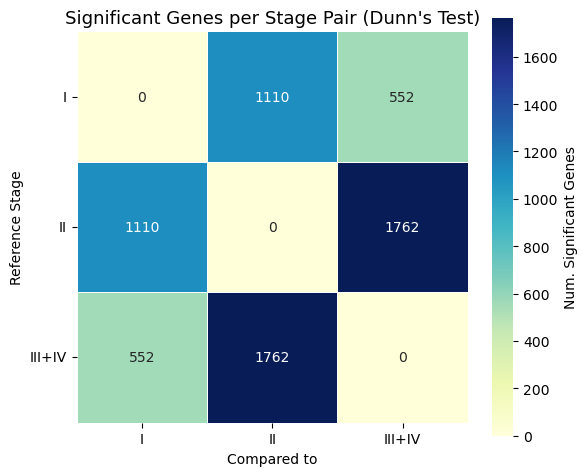

In [ ]:
#significant genes per stage
pair_counts = sig_dunn_cleaned.groupby(["pair", "compared_to"])["gene"].nunique().reset_index()

#sort stage pairs
pair_counts["stage_pair"] = pair_counts.apply(
    lambda row: tuple(sorted([row["pair"], row["compared_to"]])), axis=1
)

agg_counts = pair_counts.groupby("stage_pair")["gene"].max().reset_index()
agg_counts[["stage1", "stage2"]] = pd.DataFrame(agg_counts["stage_pair"].tolist(), index=agg_counts.index)


heatmap_data = agg_counts.pivot(index="stage1", columns="stage2", values="gene")

#fill both triangles
all_stages = sorted(set(heatmap_data.index) | set(heatmap_data.columns))
heatmap_data = heatmap_data.reindex(index=all_stages, columns=all_stages)

#mirror lower and upper triangle
for i in all_stages:
    for j in all_stages:
        if pd.isna(heatmap_data.loc[i, j]) and not pd.isna(heatmap_data.loc[j, i]):
            heatmap_data.loc[i, j] = heatmap_data.loc[j, i]
        elif pd.isna(heatmap_data.loc[j, i]) and not pd.isna(heatmap_data.loc[i, j]):
            heatmap_data.loc[j, i] = heatmap_data.loc[i, j]


np.fill_diagonal(heatmap_data.values, 0)


plt.figure(figsize=(6, 5))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlGnBu",  
    square=True, 
    linewidths=0.5, 
    cbar_kws={"label": "Num. Significant Genes"}
)
plt.title("Significant Genes per Stage Pair (Dunn's Test)", fontsize=13)
plt.xlabel("Compared to")
plt.ylabel("Reference Stage")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/rm/wt2wfw8n19bfttwsg7hy906r0000gn/T/ipykernel_22188/1450654093.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_counts.values, y=gene_counts.index, palette="YlGnBu")


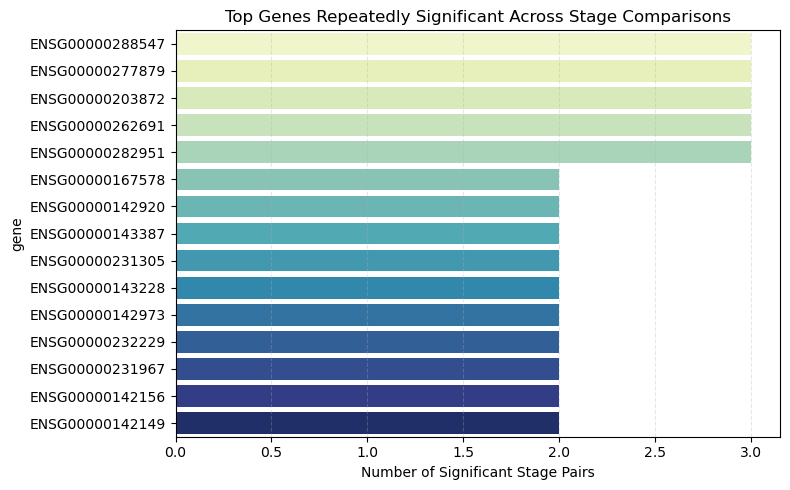

In [22]:
gene_counts = sig_dunn_cleaned["gene"].value_counts().head(15)

plt.figure(figsize=(8, 5))
sns.barplot(x=gene_counts.values, y=gene_counts.index, palette="YlGnBu")
plt.xlabel("Number of Significant Stage Pairs")
plt.title("Top Genes Repeatedly Significant Across Stage Comparisons")
plt.grid(True, axis='x', linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()